Author: Kunal Kotian  
Date: Aug 6, 2018

In [12]:
%matplotlib inline

In [105]:
import random
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim

In [2]:
# enable display of logging output
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.DEBUG)

In [43]:
plt.rcParams['figure.figsize'] = [9, 7]

# A: Topic Modeling

In order to group the articles into distinct topics, the Latent Dirichlet Allocation (LDA) method is used in this notebook.

## A.1: Load Preprocessed Text

Please refer to the notebook `part_1_text_preprocessing.ipynb` to view the steps followed for preprocessing the `10000` articles in the dataset.  Here, we start off by loading the result of text preprocessing for topic modeling, namely, a tokenized representation of the text corpus and a vocabulary built on top of it.

In [3]:
# load the tokenized articles and the vocabulary dict saved in part_1_text_preprocesing.ipynb
with open('../data/tokenized_articles.pkl', 'rb') as file:
    tokenized_articles = pickle.load(file)
    
vocab_dictionary = Dictionary.load('../data/vocab_dictionary.pkl')

INFO : loading Dictionary object from ../data/vocab_dictionary.pkl
DEBUG : {'kw': {}, 'mode': 'rb', 'uri': '../data/vocab_dictionary.pkl'}
DEBUG : encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'rb', 'fileobj': <_io.BufferedReader name='../data/vocab_dictionary.pkl'>}
INFO : loaded ../data/vocab_dictionary.pkl


In [4]:
print(vocab_dictionary)   # brief look into the vocabulary

Dictionary(8593 unique tokens: ['1,000', '10', '1950', '2005', '2016']...)


In [5]:
# create a bag-of-words representation of the corpus, i.e. doc-term matrix:
bow_corpus = [vocab_dictionary.doc2bow(article) for article in tokenized_articles]

## A.2: Selection of the Number of Topics

In this section, multiple LDA models with different number of topics are trained on the text corpus.  A "topic coherence score" is computed for each trained LDA model.  The coherence score is a measure of the quality of the topics generated by an LDA model.  Multiple LDA models can be compared using their topic coherence scores; the higher the coherence score, the better the model's topics.  Thus, the coherence score can be used as a guideline for selection of the number of topics.

### A.2.1:  Train LDA Models with Different Number of Topics

Let's start off by exploring LDA models trained on `2`, `3`, `4`, `5`, `6`, and `7` topics:

**Note on the large amount of logging output from the LDA models' training:**  
The training log output was displayed because it helps understand whether the LDA models are training properly and provides an indication of whether appropriate model parameters (particularly, `passes`, and `iterations`) were used.

**Interactive visualization of topics:**  
For each LDA model trained, an interactive visualization of the nature of its topics is created using the `pyLDAvis` module and saved.

In [31]:
%%time

# Set training parameters.
num_topics_all = range(2, 8)
# asymmetric prior (learned from data) for the per-document topic distribution:
alpha = 'auto'
# symmetric prior over per-topic word distributions (sometimes called 'beta')
eta = 'symmetric'

chunksize = 10000    # number of docs processed at a time
passes = 15          # number of epochs of training

coherence_scores = []
for num_topics in num_topics_all:
    print('Training LDA model for {} topics...'.format(num_topics))
    lda = LdaModel(bow_corpus, num_topics=num_topics, id2word=vocab_dictionary, chunksize=chunksize, 
                   passes=passes, eta=eta, alpha=alpha, eval_every=None, iterations=400, random_state=42)
    # compute evaluation metric
    coherence_lda = CoherenceModel(model=lda, corpus=bow_corpus, dictionary=vocab_dictionary, coherence='u_mass')
    coherence_scores.append(coherence_lda.get_coherence())
    print('UMass topic model coherence score is: ', coherence_lda.get_coherence())
    # create interactive visualization
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, vocab_dictionary)
    plot_file = '../outputs/pyLDAvis_{}.html'.format(num_topics)
    pyLDAvis.save_html(vis, plot_file)
    print('Saved topic model visualization as:', plot_file)
    # save lda model
    lda.save('../outputs/lda_{}_topics.pkl'.format(num_topics))

INFO : using autotuned alpha, starting with [0.5, 0.5]
INFO : using symmetric eta at 0.5
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 2 topics, 15 passes over the supplied corpus of 10000 documents, updating model once every 10000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents


Training LDA model for 2 topics...


DEBUG : 4786/10000 documents converged within 400 iterations
INFO : optimized alpha [0.35530224, 0.20047757]
DEBUG : updating topics
INFO : topic #0 (0.355): 0.006*"2017" + 0.004*"good" + 0.004*"company" + 0.003*"use" + 0.003*"report" + 0.003*"game" + 0.003*"2018" + 0.003*"need" + 0.003*"lead" + 0.003*"win"
INFO : topic #1 (0.200): 0.005*"market" + 0.004*"trump" + 0.004*"2018" + 0.004*"people" + 0.004*"good" + 0.004*"like" + 0.003*"state" + 0.003*"company" + 0.003*"world" + 0.003*"work"
INFO : topic diff=1.120379, rho=1.000000
INFO : PROGRESS: pass 1, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9508/10000 documents converged within 400 iterations
INFO : optimized alpha [0.20654675, 0.15141055]
DEBUG : updating topics
INFO : topic #0 (0.207): 0.006*"2017" + 0.005*"good" + 0.004*"company" + 0.004*"report" + 0.004*"game" + 0.003*"use" + 0.003*"win" + 0.003*"lead" + 0.003*"need" + 0.003*"2018"
INFO : topic #1 (0.151): 0.005*"trump" + 0.004*"m

INFO : topic diff=0.031186, rho=0.267261
INFO : PROGRESS: pass 13, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9983/10000 documents converged within 400 iterations
INFO : optimized alpha [0.12236139, 0.11525112]
DEBUG : updating topics
INFO : topic #0 (0.122): 0.008*"2017" + 0.007*"market" + 0.006*"company" + 0.005*"good" + 0.005*"2018" + 0.005*"game" + 0.004*"business" + 0.004*"win" + 0.003*"lead" + 0.003*"report"
INFO : topic #1 (0.115): 0.006*"trump" + 0.005*"people" + 0.004*"state" + 0.003*"like" + 0.003*"work" + 0.003*"tell" + 0.003*"day" + 0.003*"man" + 0.003*"know" + 0.003*"use"
INFO : topic diff=0.028622, rho=0.258199
INFO : PROGRESS: pass 14, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9986/10000 documents converged within 400 iterations
INFO : optimized alpha [0.1230508, 0.116815835]
DEBUG : updating topics
INFO : topic #0 (0.123): 0.008*"2017" + 0.007*"market" + 0.006*"company" + 

UMass topic model coherence score is:  -1.2978081138431676


DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9982/10000 documents converged within 400 iterations
/Users/kunal/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
INFO : using autotuned alpha, starting with [0.33333334, 0.33333334, 0.33333334]
INFO : using symmetric eta at 0.3333333333333333
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 3 topics, 15 passes over the supplied corpus of 10000 documents, updating model once every 10000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #10000/10000
DEBUG : performing inference on 

Saved topic model visualization as: pyLDAvis_2.html
Training LDA model for 3 topics...


DEBUG : 5890/10000 documents converged within 400 iterations
INFO : optimized alpha [0.33333334, 0.33333334, 0.33333334]
DEBUG : updating topics
INFO : topic #0 (0.333): 0.007*"2017" + 0.005*"good" + 0.005*"company" + 0.004*"report" + 0.004*"use" + 0.003*"game" + 0.003*"win" + 0.003*"need" + 0.003*"lead" + 0.003*"market"
INFO : topic #1 (0.333): 0.006*"market" + 0.005*"trump" + 0.004*"good" + 0.004*"people" + 0.004*"like" + 0.004*"company" + 0.003*"2018" + 0.003*"world" + 0.003*"review" + 0.003*"way"
INFO : topic #2 (0.333): 0.005*"2018" + 0.004*"day" + 0.004*"state" + 0.003*"plan" + 0.003*"people" + 0.003*"good" + 0.003*"like" + 0.003*"2017" + 0.003*"work" + 0.003*"man"
INFO : topic diff=1.163547, rho=1.000000
INFO : PROGRESS: pass 1, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9364/10000 documents converged within 400 iterations
INFO : optimized alpha [0.2235905, 0.16886628, 0.15420182]
DEBUG : updating topics
INFO : topic #0 (0.224): 0

INFO : topic diff=0.057139, rho=0.301511
INFO : PROGRESS: pass 10, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9963/10000 documents converged within 400 iterations
INFO : optimized alpha [0.12036379, 0.10374312, 0.090696916]
DEBUG : updating topics
INFO : topic #0 (0.120): 0.010*"2017" + 0.008*"market" + 0.007*"company" + 0.006*"game" + 0.006*"good" + 0.005*"win" + 0.004*"lead" + 0.004*"business" + 0.004*"report" + 0.004*"global"
INFO : topic #1 (0.104): 0.005*"review" + 0.004*"people" + 0.004*"use" + 0.004*"police" + 0.004*"like" + 0.004*"good" + 0.004*"case" + 0.004*"know" + 0.004*"find" + 0.004*"man"
INFO : topic #2 (0.091): 0.007*"trump" + 0.005*"2018" + 0.005*"state" + 0.005*"plan" + 0.004*"u.s." + 0.004*"government" + 0.004*"people" + 0.004*"tax" + 0.004*"work" + 0.003*"president"
INFO : topic diff=0.053543, rho=0.288675
INFO : PROGRESS: pass 11, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEB

UMass topic model coherence score is:  -1.3781296483612682


DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9981/10000 documents converged within 400 iterations
/Users/kunal/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
INFO : using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
INFO : using symmetric eta at 0.25
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 4 topics, 15 passes over the supplied corpus of 10000 documents, updating model once every 10000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents

Saved topic model visualization as: pyLDAvis_3.html
Training LDA model for 4 topics...


DEBUG : 5978/10000 documents converged within 400 iterations
INFO : optimized alpha [0.25, 0.25, 0.25, 0.25]
DEBUG : updating topics
INFO : topic #0 (0.250): 0.006*"2017" + 0.005*"good" + 0.004*"company" + 0.004*"win" + 0.004*"need" + 0.004*"use" + 0.003*"report" + 0.003*"game" + 0.003*"market" + 0.003*"lead"
INFO : topic #1 (0.250): 0.006*"market" + 0.005*"trump" + 0.004*"good" + 0.004*"people" + 0.004*"like" + 0.004*"review" + 0.003*"2018" + 0.003*"week" + 0.003*"world" + 0.003*"way"
INFO : topic #2 (0.250): 0.006*"2018" + 0.004*"state" + 0.004*"people" + 0.003*"day" + 0.003*"plan" + 0.003*"man" + 0.003*"work" + 0.003*"good" + 0.003*"government" + 0.003*"like"
INFO : topic #3 (0.250): 0.005*"2017" + 0.005*"company" + 0.004*"look" + 0.004*"business" + 0.004*"school" + 0.003*"report" + 0.003*"state" + 0.003*"day" + 0.003*"market" + 0.003*"use"
INFO : topic diff=1.204607, rho=1.000000
INFO : PROGRESS: pass 1, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 docu

INFO : PROGRESS: pass 8, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9959/10000 documents converged within 400 iterations
INFO : optimized alpha [0.09947872, 0.08784868, 0.078464925, 0.08529104]
DEBUG : updating topics
INFO : topic #0 (0.099): 0.008*"game" + 0.007*"win" + 0.007*"good" + 0.005*"play" + 0.005*"2017" + 0.005*"team" + 0.004*"season" + 0.004*"lead" + 0.004*"home" + 0.004*"late"
INFO : topic #1 (0.088): 0.006*"review" + 0.005*"people" + 0.005*"good" + 0.005*"like" + 0.004*"week" + 0.004*"know" + 0.004*"apple" + 0.004*"case" + 0.004*"video" + 0.004*"want"
INFO : topic #2 (0.078): 0.010*"trump" + 0.006*"state" + 0.005*"government" + 0.005*"u.s." + 0.005*"plan" + 0.004*"tax" + 0.004*"2018" + 0.004*"people" + 0.004*"president" + 0.003*"bill"
INFO : topic #3 (0.085): 0.010*"company" + 0.010*"market" + 0.010*"2017" + 0.007*"business" + 0.006*"global" + 0.005*"report" + 0.005*"million" + 0.005*"industry" + 0.004*"2018" + 0.004*"servic

UMass topic model coherence score is:  -1.3692293956100101


DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9985/10000 documents converged within 400 iterations
/Users/kunal/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
INFO : using symmetric eta at 0.2
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 5 topics, 15 passes over the supplied corpus of 10000 documents, updating model once every 10000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents

Saved topic model visualization as: pyLDAvis_4.html
Training LDA model for 5 topics...


DEBUG : 5956/10000 documents converged within 400 iterations
INFO : optimized alpha [0.100676015, 0.047969654, 0.025852501, 0.02387856, 0.055192098]
DEBUG : updating topics
INFO : topic #0 (0.101): 0.007*"2017" + 0.006*"good" + 0.005*"company" + 0.004*"use" + 0.004*"win" + 0.004*"report" + 0.003*"game" + 0.003*"market" + 0.003*"need" + 0.003*"help"
INFO : topic #1 (0.048): 0.006*"trump" + 0.005*"good" + 0.005*"market" + 0.004*"review" + 0.004*"people" + 0.004*"like" + 0.003*"2018" + 0.003*"week" + 0.003*"want" + 0.003*"company"
INFO : topic #2 (0.026): 0.005*"2018" + 0.004*"people" + 0.003*"plan" + 0.003*"good" + 0.003*"government" + 0.003*"man" + 0.003*"like" + 0.003*"work" + 0.003*"state" + 0.003*"day"
INFO : topic #3 (0.024): 0.006*"2017" + 0.005*"company" + 0.005*"look" + 0.004*"business" + 0.003*"report" + 0.003*"use" + 0.003*"school" + 0.003*"include" + 0.003*"software" + 0.003*"big"
INFO : topic #4 (0.055): 0.005*"market" + 0.004*"state" + 0.004*"day" + 0.004*"2018" + 0.004*"cit

INFO : topic #4 (0.054): 0.006*"city" + 0.006*"man" + 0.005*"day" + 0.004*"people" + 0.004*"school" + 0.004*"state" + 0.004*"know" + 0.004*"police" + 0.003*"2018" + 0.003*"home"
INFO : topic diff=0.118998, rho=0.353553
INFO : PROGRESS: pass 7, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9957/10000 documents converged within 400 iterations
INFO : optimized alpha [0.05799802, 0.046560857, 0.035217654, 0.037218176, 0.054391693]
DEBUG : updating topics
INFO : topic #0 (0.058): 0.010*"game" + 0.009*"win" + 0.009*"good" + 0.007*"2017" + 0.006*"play" + 0.005*"season" + 0.005*"team" + 0.005*"late" + 0.005*"10" + 0.004*"point"
INFO : topic #1 (0.047): 0.008*"review" + 0.007*"good" + 0.006*"trump" + 0.006*"apple" + 0.005*"like" + 0.005*"video" + 0.005*"case" + 0.005*"week" + 0.005*"people" + 0.004*"want"
INFO : topic #2 (0.035): 0.009*"trump" + 0.006*"government" + 0.006*"u.s." + 0.005*"state" + 0.005*"plan" + 0.005*"tax" + 0.005*"2018" + 0.004*"pr

INFO : topic #2 (0.042): 0.014*"trump" + 0.007*"government" + 0.007*"u.s." + 0.006*"state" + 0.006*"tax" + 0.005*"plan" + 0.005*"president" + 0.004*"bill" + 0.004*"india" + 0.004*"people"
INFO : topic #3 (0.050): 0.012*"market" + 0.012*"company" + 0.010*"2017" + 0.008*"business" + 0.007*"global" + 0.006*"report" + 0.006*"million" + 0.006*"industry" + 0.005*"2018" + 0.005*"service"
INFO : topic #4 (0.060): 0.007*"city" + 0.007*"man" + 0.007*"police" + 0.006*"school" + 0.005*"day" + 0.005*"people" + 0.004*"home" + 0.004*"old" + 0.004*"report" + 0.004*"find"
INFO : topic diff=0.078985, rho=0.258199
INFO : PROGRESS: pass 14, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9986/10000 documents converged within 400 iterations
INFO : optimized alpha [0.05486807, 0.05220638, 0.04316907, 0.05195996, 0.06075633]
DEBUG : updating topics
INFO : topic #0 (0.055): 0.013*"game" + 0.011*"win" + 0.008*"good" + 0.008*"play" + 0.007*"season" + 0.007*"team" + 0.

UMass topic model coherence score is:  -1.454037301132423


DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9988/10000 documents converged within 400 iterations
/Users/kunal/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
INFO : using autotuned alpha, starting with [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667]
INFO : using symmetric eta at 0.16666666666666666
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 6 topics, 15 passes over the supplied corpus of 10000 documents, updating model once every 10000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #10000/1

Saved topic model visualization as: pyLDAvis_5.html
Training LDA model for 6 topics...


DEBUG : 5956/10000 documents converged within 400 iterations
INFO : optimized alpha [0.10055942, 0.062395304, 0.045791194, 0.043930568, 0.06787703, 0.02667819]
DEBUG : updating topics
INFO : topic #5 (0.027): 0.009*"market" + 0.004*"business" + 0.004*"think" + 0.004*"state" + 0.004*"lead" + 0.003*"team" + 0.003*"man" + 0.003*"come" + 0.003*"global" + 0.003*"like"
INFO : topic #3 (0.044): 0.006*"2017" + 0.005*"company" + 0.005*"look" + 0.004*"business" + 0.003*"report" + 0.003*"software" + 0.003*"use" + 0.003*"school" + 0.003*"include" + 0.003*"good"
INFO : topic #1 (0.062): 0.006*"trump" + 0.005*"good" + 0.005*"review" + 0.004*"people" + 0.004*"market" + 0.004*"like" + 0.004*"2018" + 0.003*"week" + 0.003*"want" + 0.003*"world"
INFO : topic #4 (0.068): 0.004*"2018" + 0.004*"day" + 0.004*"state" + 0.004*"city" + 0.004*"company" + 0.003*"lead" + 0.003*"high" + 0.003*"need" + 0.003*"market" + 0.003*"know"
INFO : topic #0 (0.101): 0.008*"2017" + 0.006*"good" + 0.005*"company" + 0.004*"win" 

INFO : topic #4 (0.059): 0.007*"city" + 0.006*"day" + 0.006*"man" + 0.004*"people" + 0.004*"know" + 0.004*"school" + 0.004*"state" + 0.004*"amazon" + 0.004*"home" + 0.004*"2018"
INFO : topic #0 (0.065): 0.011*"game" + 0.009*"good" + 0.009*"win" + 0.008*"2017" + 0.006*"play" + 0.005*"late" + 0.005*"team" + 0.005*"season" + 0.005*"10" + 0.004*"woman"
INFO : topic diff=0.128116, rho=0.353553
INFO : PROGRESS: pass 7, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9959/10000 documents converged within 400 iterations
INFO : optimized alpha [0.06402451, 0.05324269, 0.04539685, 0.05076855, 0.05991967, 0.03258054]
DEBUG : updating topics
INFO : topic #5 (0.033): 0.014*"market" + 0.004*"kill" + 0.004*"business" + 0.004*"trade" + 0.004*"state" + 0.004*"student" + 0.004*"p.m." + 0.003*"school" + 0.003*"eu" + 0.003*"report"
INFO : topic #2 (0.045): 0.007*"2018" + 0.007*"trump" + 0.006*"u.s." + 0.006*"government" + 0.006*"plan" + 0.005*"state" + 0.005*"in

INFO : topic #2 (0.048): 0.014*"trump" + 0.007*"u.s." + 0.007*"government" + 0.007*"state" + 0.006*"tax" + 0.006*"plan" + 0.006*"president" + 0.006*"2018" + 0.005*"india" + 0.004*"people"
INFO : topic #0 (0.060): 0.014*"game" + 0.012*"win" + 0.010*"good" + 0.008*"play" + 0.007*"season" + 0.007*"2017" + 0.007*"team" + 0.006*"10" + 0.005*"lead" + 0.005*"late"
INFO : topic #3 (0.062): 0.013*"company" + 0.011*"2017" + 0.009*"market" + 0.007*"business" + 0.007*"global" + 0.006*"report" + 0.006*"industry" + 0.006*"million" + 0.005*"service" + 0.005*"2018"
INFO : topic #4 (0.065): 0.007*"city" + 0.007*"man" + 0.006*"day" + 0.006*"police" + 0.005*"people" + 0.005*"home" + 0.004*"school" + 0.004*"know" + 0.004*"find" + 0.004*"old"
INFO : topic diff=0.090159, rho=0.258199
INFO : PROGRESS: pass 14, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9983/10000 documents converged within 400 iterations
INFO : optimized alpha [0.060159594, 0.056853913, 0.0484

UMass topic model coherence score is:  -1.5641144960126656


DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9976/10000 documents converged within 400 iterations
/Users/kunal/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
INFO : using autotuned alpha, starting with [0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715]
INFO : using symmetric eta at 0.14285714285714285
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 7 topics, 15 passes over the supplied corpus of 10000 documents, updating model once every 10000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at docum

Saved topic model visualization as: pyLDAvis_6.html
Training LDA model for 7 topics...


DEBUG : 6062/10000 documents converged within 400 iterations
INFO : optimized alpha [0.08915338, 0.060402893, 0.050763473, 0.04820604, 0.06486103, 0.036937833, 0.07494541]
DEBUG : updating topics
INFO : topic #5 (0.037): 0.012*"market" + 0.004*"think" + 0.004*"lead" + 0.003*"global" + 0.003*"state" + 0.003*"business" + 0.003*"2017" + 0.003*"come" + 0.003*"kill" + 0.003*"man"
INFO : topic #3 (0.048): 0.007*"2017" + 0.006*"company" + 0.005*"look" + 0.004*"software" + 0.004*"report" + 0.003*"fourth__quarter" + 0.003*"use" + 0.003*"big" + 0.003*"business" + 0.003*"include"
INFO : topic #4 (0.065): 0.005*"2018" + 0.004*"day" + 0.004*"company" + 0.004*"market" + 0.004*"lead" + 0.004*"state" + 0.004*"transcript" + 0.003*"need" + 0.003*"trump" + 0.003*"high"
INFO : topic #6 (0.075): 0.007*"game" + 0.005*"week" + 0.004*"like" + 0.004*"play" + 0.004*"business" + 0.004*"people" + 0.004*"season" + 0.004*"state" + 0.004*"city" + 0.003*"work"
INFO : topic #0 (0.089): 0.009*"2017" + 0.007*"good" + 0.

INFO : topic #4 (0.052): 0.006*"city" + 0.005*"man" + 0.005*"amazon" + 0.005*"day" + 0.005*"people" + 0.004*"need" + 0.004*"transcript" + 0.004*"know" + 0.004*"home" + 0.004*"fire"
INFO : topic #0 (0.054): 0.013*"2017" + 0.009*"good" + 0.007*"police" + 0.007*"late" + 0.007*"woman" + 0.006*"company" + 0.006*"stock" + 0.005*"report" + 0.004*"women" + 0.004*"tech"
INFO : topic #6 (0.072): 0.011*"game" + 0.008*"win" + 0.007*"play" + 0.006*"season" + 0.006*"team" + 0.006*"good" + 0.005*"week" + 0.005*"like" + 0.004*"day" + 0.004*"come"
INFO : topic diff=0.143112, rho=0.353553
INFO : PROGRESS: pass 7, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9956/10000 documents converged within 400 iterations
INFO : optimized alpha [0.053123895, 0.047722284, 0.046623863, 0.050414074, 0.052218772, 0.036108375, 0.071987435]
DEBUG : updating topics
INFO : topic #5 (0.036): 0.022*"market" + 0.005*"trade" + 0.005*"kill" + 0.004*"global" + 0.004*"report" + 0.004*

INFO : PROGRESS: pass 13, at document #10000/10000
DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9980/10000 documents converged within 400 iterations
INFO : optimized alpha [0.04971368, 0.048304357, 0.049485106, 0.05935581, 0.05717949, 0.037364393, 0.07538023]
DEBUG : updating topics
INFO : topic #5 (0.037): 0.021*"market" + 0.007*"trade" + 0.006*"bitcoin" + 0.005*"school" + 0.005*"rise" + 0.004*"economy" + 0.004*"kill" + 0.004*"eu" + 0.004*"bank" + 0.004*"brexit"
INFO : topic #1 (0.048): 0.016*"trump" + 0.013*"review" + 0.009*"apple" + 0.007*"case" + 0.006*"use" + 0.006*"good" + 0.006*"google" + 0.005*"want" + 0.005*"like" + 0.005*"china"
INFO : topic #4 (0.057): 0.007*"city" + 0.007*"man" + 0.006*"people" + 0.005*"home" + 0.005*"day" + 0.005*"fire" + 0.004*"amazon" + 0.004*"find" + 0.004*"know" + 0.004*"transcript"
INFO : topic #3 (0.059): 0.013*"company" + 0.011*"2017" + 0.008*"business" + 0.007*"market" + 0.007*"global" + 0.007*"industry" + 0.006*"million" + 0.

UMass topic model coherence score is:  -1.7309276720689843


DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9972/10000 documents converged within 400 iterations
/Users/kunal/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


Saved topic model visualization as: pyLDAvis_7.html
CPU times: user 27min 11s, sys: 1min, total: 28min 11s
Wall time: 27min 43s


### A.2.2:  Evaluate LDA Models with Different Number of Topics

The plot below shows the variation of the coherence score of the LDA models with an increase in the number of topics from `2` to `7`.  


While the coherence score at `2` topics is the highest, upon investigation of its interactive topic visualization, this LDA model appeared to be too simplistic to be useful.  

On the other hand, the peak at `4` topics indicates that a good values for the number of topics is close to `4`. Upon investigating the pyLDAvis visualizations of topics for LDA models with `4`, and `5` topics, it appeared that **the LDA model with `5` topics provided the most distinct and cohesive topics.**

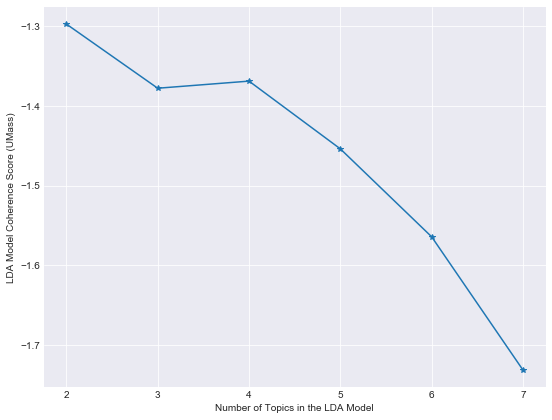

In [44]:
sns.set_style("darkgrid")
plt.plot(list(range(2, 8)), coherence_scores, '-*')
plt.xlabel('Number of Topics in the LDA Model')
plt.ylabel('LDA Model Coherence Score (UMass)');

### A.2.3:  Interpretation of the Topics in the Selected LDA Model

The topics generated by the LDA model can be interpreted in terms of the their constituent words.  In particular, looking at the top few words in each topic having highest probabilities can provide insight on the nature of the topics:

In [70]:
topics = lda_5_topics.show_topics(num_topics=5, num_words=8)

print('Words with highest probabilities in each topic: \n')
for i in range(len(topics)):
    print('Topic {}: '.format(i + 1))
    print(topics[i][1], '\n')

Words with highest probabilities in each topic: 

Topic 1: 
0.013*"game" + 0.011*"win" + 0.008*"good" + 0.008*"play" + 0.007*"season" + 0.007*"team" + 0.007*"2017" + 0.005*"lead" 

Topic 2: 
0.009*"good" + 0.008*"review" + 0.007*"like" + 0.006*"apple" + 0.005*"people" + 0.005*"video" + 0.005*"thing" + 0.005*"use" 

Topic 3: 
0.014*"trump" + 0.007*"government" + 0.007*"u.s." + 0.006*"state" + 0.006*"tax" + 0.005*"plan" + 0.005*"president" + 0.004*"bill" 

Topic 4: 
0.013*"market" + 0.012*"company" + 0.011*"2017" + 0.008*"business" + 0.007*"global" + 0.006*"report" + 0.006*"million" + 0.006*"industry" 

Topic 5: 
0.007*"man" + 0.007*"city" + 0.007*"police" + 0.006*"school" + 0.005*"day" + 0.005*"people" + 0.004*"home" + 0.004*"old" 



A more nuanced way of gaining insight into the nature of the topics is through the interactive visualization created using `pyLDAvis`.
This visualization, shown below in this section, is based on the LDAvis visualization method explained in [this](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [45]:
pyLDAvis.enable_notebook()

In [48]:
lda_5_topics = LdaModel.load('../outputs/lda_5_topics.pkl')

INFO : loading LdaModel object from ../outputs/lda_5_topics.pkl
DEBUG : {'kw': {}, 'mode': 'rb', 'uri': '../outputs/lda_5_topics.pkl'}
DEBUG : encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'rb', 'fileobj': <_io.BufferedReader name='../outputs/lda_5_topics.pkl'>}
INFO : loading expElogbeta from ../outputs/lda_5_topics.pkl.expElogbeta.npy with mmap=None
INFO : setting ignored attribute state to None
INFO : setting ignored attribute id2word to None
INFO : setting ignored attribute dispatcher to None
INFO : loaded ../outputs/lda_5_topics.pkl
INFO : loading LdaState object from ../outputs/lda_5_topics.pkl.state
DEBUG : {'kw': {}, 'mode': 'rb', 'uri': '../outputs/lda_5_topics.pkl.state'}
DEBUG : encoding_wrapper: {'errors': 'strict', 'encoding': None, 'mode': 'rb', 'fileobj': <_io.BufferedReader name='../outputs/lda_5_topics.pkl.state'>}
INFO : loaded ../outputs/lda_5_topics.pkl.state
DEBUG : {'kw': {}, 'mode': 'rb', 'uri': '../outputs/lda_5_topics.pkl.id2word'}
DEBUG : en

In [49]:
vis = pyLDAvis.gensim.prepare(lda_5_topics, bow_corpus, vocab_dictionary, sort_topics=False)
vis

DEBUG : performing inference on a chunk of 10000 documents
DEBUG : 9988/10000 documents converged within 400 iterations
/Users/kunal/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      16.482752        1       1  0.100277 -0.109818
1      18.820686        1       2  0.038624  0.010440
2      19.354362        1       3 -0.038526  0.123427
3      25.907078        1       4 -0.184837 -0.064595
4      19.435116        1       5  0.084462  0.040546, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
599   Default   9065.000000       trump   9065.000000  30.0000  30.0000
386   Default   7749.000000        game   7749.000000  29.0000  29.0000
870   Default  11047.000000      market  11047.000000  28.0000  28.0000
475   Default   6714.000000         win   6714.000000  27.0000  27.0000
41    Default  11788.000000     company  11788.000000  26.0000  26.0000
493   Default  13041.000000        2017  13041.000000  25.0000  25.0000
488   Default   5287.000000      review   5287.000000  24.0000  24.0000
94    Default   5522.000000      global   5522.000000  23.0000  23.0000
441   Default   4224.000000      season   4224.000000  22.0000  22.0000
295   Default   4462.000000      police   4462.000000  21.0000  21.0000
906   Default   3425.000000       apple   3425.000000  20.0000  20.0000
97    Default   5188.000000  government   5188.000000  19.0000  19.0000
422   Default   5915.000000        play   5915.000000  18.0000  18.0000
96    Default  12637.000000        good  12637.000000  17.0000  17.0000
486   Default   5526.000000         man   5526.000000  16.0000  16.0000
1762  Default   4025.000000         tax   4025.000000  15.0000  15.0000
624   Default   5476.000000        city   5476.000000  14.0000  14.0000
301   Default   4446.000000      school   4446.000000  13.0000  13.0000
250   Default   5919.000000        u.s.   5919.000000  12.0000  12.0000
954   Default   5203.000000    industry   5203.000000  11.0000  11.0000
32    Default   8136.000000    business   8136.000000  10.0000  10.0000
236   Default   5924.000000        team   5924.000000   9.0000   9.0000
1265  Default   3853.000000       video   3853.000000   8.0000   8.0000
787   Default   4026.000000   president   4026.000000   7.0000   7.0000
860   Default   3264.000000      growth   3264.000000   6.0000   6.0000
1103  Default   2508.000000        inc.   2508.000000   5.0000   5.0000
1771  Default   2892.000000        bill   2892.000000   4.0000   4.0000
2142  Default   2029.000000    election   2029.000000   3.0000   3.0000
3382  Default   2214.000000      google   2214.000000   2.0000   2.0000
423   Default   3057.000000      player   3057.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
2884   Topic5    621.116882      murder    755.270203   1.4425  -6.8764
740    Topic5   1079.419678      county   1468.597778   1.3302  -6.3237
1492   Topic5   1515.045166      attack   2267.494629   1.2349  -5.9847
514    Topic5   1387.385864         car   2069.900146   1.2380  -6.0727
307    Topic5   1610.287598     student   2512.852051   1.1931  -5.9237
156    Topic5   2269.177246         old   4143.713379   1.0359  -5.5807
2827   Topic5    799.521973        town   1049.492676   1.3660  -6.6239
948    Topic5    836.541565     holiday   1119.730957   1.3465  -6.5786
1534   Topic5   2040.647217      family   3880.290039   0.9954  -5.6869
1770   Topic5    996.408508         air   1430.346924   1.2766  -6.4037
57     Topic5   3250.917236         day   8142.068359   0.7200  -5.2212
543    Topic5   2590.582031        home   5887.863770   0.8171  -5.4483
274    Topic5   1633.957397      charge   3005.318848   1.0287  -5.9091
1521   Topic5   1415.136597         die   2529.878174   1.0571  -6.0529
164    Topic5   2940.311523      people   9357.510742   0.4804  -5.3216
736    Topic5   1598.720581       child   3394.885742   0.8850  -5.9309
265    Topic5   2015.778809       woman   5225.6152

The visualization above is interactive. Hovering over/clicking on the topics (bubbles) on the left side updates the list of terms 'relevant' to that topic.  The terms representative of the selected topic shown on the right side are ranked in terms of a measure called 'relevance' defined in [this](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)  paper.  Changing the value of $\lambda$ using the slider at the top right affects the way the terms are ranked and highlighted.  Low values of $\lambda$ cause highly relevant but rare tokens to get highlighted, while high $\lambda$ values lead to highlighting of frequently appearing tokens that may not be uniquely asociated with that topic.

*Note that if all the bubbles on the left appear blue, that indicates that no topic is selected; in this case the terms on the right side are reresentative of the entire corpus.*

By adjusting the value of $\lambda$ for each topic ($\lambda$ = `0.6` is a good starting point, as recommended by [this](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)  paper) and observing the highlighted relevant terms, we can infer the nature of the generated topics.  

**Below are the topic labels that reflect (in my opinion) the nature of the topics:**  

* Topic 1: Sports 
* Topic 2: Technology and Entertainment
* Topic 3: Politics
* Topic 4: Business, Finance, and Economics
* Topic 5: Crime and Accidents

All articles in the corpus can be grouped into the 5 categories above.

# B: Assignment of Articles to Topics

In [113]:
topic_labels = {
    1: 'Sports',
    2: 'Technology and Entertainment',
    3: 'Politics',
    4: 'Business, Finance, and Economics',
    5: 'Crime and Accidents'
}

In [115]:
# for each article (document), get the topic probabilities
article_topics = lda_5_topics.get_document_topics(bow_corpus)

# Assign each document to the topic that has the highest probability
topic_membership = []
for topic_prob in article_topics:
    # add 1 to start indexing from 1, to match with pyLDAvis' topic numbers
    topic_num = max(topic_prob, key=lambda x: x[1])[0] + 1
    topic_membership.append(topic_num)
    
# load articles list from part_1_text_preprocessing.ipynb; its format is: 
# [[document index in the original JSON array, article title, article text]]
with open('../data/articles.pkl', 'rb') as file:
    articles = pickle.load(file)
    
# update each article's list in articles by adding its topic's name as the 4th element
# [[document index in the original JSON array, article title, article text, topic name]]
for i in range(len(articles)):
    topic_num = topic_membership[i]
    topic_name = topic_labels[topic_num]
    articles[i].append(topic_name)

## B.1 Check Article Assignment to Topics

We can verify that the article assignment to topics is reasonable for a few documents manually. 

In [132]:
article_index = random.randint(0, 9999)
articles[article_index]

[8907,
 'Royals OF Bonifacio banned 80 games for positive drug test | Charlotte Observer',
 'Kansas City Royals outfielder Jorge Bonifacio has been suspended 80 games after testing positive for a performance-enhancing substance.\nThe commissioner\'s office made the announcement Saturday.\nBonifacio was banned after a positive test for Boldenone. The ban will begin on opening day.\n"It really kind of made me sick to my stomach," Royals manager Ned Yost said.\nNever miss a local story.\nSign up today for a free 30 day free trial of unlimited digital access.\nSUBSCRIBE NOW\nThe 24-year-old Bonifacio made his major league debut last season, hitting .255 with 17 home runs and 40 RBIs in 113 games.\n"He is an incredible person who just made a mistake," general manager Dayton Moore said in a statement. "Jorge will have our full support as he deals with the consequences of this violation."\nKansas City was reshuffling its outfield this spring after Lorenzo Cain left as a free agent, and Bonifa

In [133]:
article_index = random.randint(0, 9999)
articles[article_index]

[1782,
 'In South Sudan, just 2 dogs patrol for wildlife trafficking',
 'JUBA, South Sudan (AP) — Leaping from the van, South Sudan’s only two patrol dogs raced toward passengers disembarking a plane in the capital, Juba. After frantically sniffing their luggage, one dog abruptly sat in front of a wary young man and stared at his bag. Removing a piece of ivory from a side pouch, the man breathed a sigh.\nIt was just a drill, though the dogs hardly need practice runs to sharpen their skills. Ivory and illegal animals regularly flow through this civil war-torn nation that advocacy groups say has become a critical hub for traffickers.\n“The breakdown of the rule of law and order and the lack of political will to combat the illicit trafficking of wildlife means that South Sudan won’t be able to stem the currently out-of-control slaughter and exploitation,” said Brian Adeba, associate director of policy at the Enough Project, a Washington-based advocacy group.\nA report by the group in July

In [134]:
article_index = random.randint(0, 9999)
articles[article_index]

[4951,
 'Anderson, Pine eye 2020 mayor’s race to replace Caldwell',
 'Never mind the buzz about the 2018 campaigns for Hawaii governor and congressional seats. Read More\n– or –',
 'Politics']

In [135]:
article_index = random.randint(0, 9999)
articles[article_index]

[2079,
 "Dean McDermott's ex-wife Mary Jo Eustace says he regrets leaving her",
 'Dean McDermott was just put under fire by ex-wife Mary Jo Eustace, who claimed her baby-daddy told her he regrets having left her for Tori Spelling , 44.\nAs RadarOnline.com has learned, Eustace came clean about her relationship with the actor, telling DailyMailTV that he cheated on her with Spelling, then married her, had five kids and now regrets his actions.\nMcDermott was married to Eustace from 1993 to 2006 – when he allegedly had an affair with Spelling. The duo divorced that year, and weeks later the star tied the knot with his current wife.\n“A year and a half ago, Dean confessed to me that he had made a mistake and he wondered what his life would be like if he had he stayed with me. He said, ‘Do I love Tori? Yeah. But I’ve thrown my life away,’” Eustace claimed. “It was the most bizarre conversation ever. It made me feel irritated. I don’t want any more drama. It was crazy, extreme behavior.”\nTh

**Observations:**  
The first 3 out of the 4 articles above appear to have been assigned to appropriate categories.  In the case of the 4th article (above), while the topic 'Crime and Accidents' seems inappropriate, it does not fit well into any of the other 4 topics either.


# C: Comments on Improvements

Some of the following items would be worth exploring for this topic modeling task beyond this point:


* The JSON data also contained URLs of the articles.  Often, these URL paths reveal how the website that hosted the article categorized it.  If the URL paths are broken down and categories are extracted, these categories could be a potentially useful signal for LDA.
* The level of boosting of title tokens (the number of times they are repeated) can be tuned.
* The `eta` hyper-parameters in training LDA models could be tuned; `eta` represents the prior over per-topic word distributions (sometimes called $\beta$).
* In some cases, the article text contains URLs that link to other articles.  All URLs in the article text can be removed.
* If the code is intended to work with significantly larger datasets, it can be made more efficient (in terms of memory and processing time) by expanding the use of generators as well as employing special objects offered by `Gensim` to support streaming-focused processing pipelines, along with employing multi-threading and parallelization.
* I have explored a different topic model called Correlation Explanation [CorEx](https://github.com/gregversteeg/corex_topic) in the past. It would be interesting to use the CorEx model for this task as well and compared the results with LDA.
* It would be interesting to employ some level of 'guidance' in topic modeling.  If it is possible to say that we are certain that topics X, Y, and Z are represented in the corpus, we can then identify tokens closely associated with X, Y, and Z and then train a guided version of LDA or an Anchored CorEx model.  'Guiding' the topic model would involve seeding some of its topics (in this example, 3 topics) with related tokens.